# Reading and understanding the data

In [2]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from chemception.chemception import Chemception
from chemception.Featurizer import ChemCeptionizer
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau

train_df = pd.read_csv('train_aid686978.csv')
# train_df = train_df.sample(frac=0.2)
train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'train_aid686978.csv'

`SMILES` are a way to represent molecules as strings. This represenation is a standard in the Chemistry community and is usually parsed to other representaions of the molecule. For example, the `RDKit` library can parse SMILES to a `Mol` object.

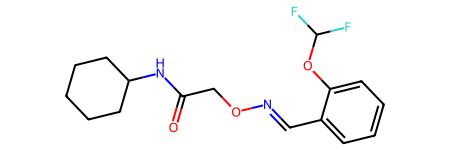

In [43]:
Chem.MolFromSmiles(train_df['smiles'].iloc[0])

We will use this represntation as a first step for our featurization. We will use the `RDKit` library to parse the SMILES to a `Mol` object for all the data.

In [44]:
train_df["mol"] = train_df["smiles"].apply(Chem.MolFromSmiles)

# Featurizing

The featurization process is the backbone of the paper we adopted, the paper chose certain feature that well describe the molecule and used them as features for the model. Which is inline with what we have learned in picking features for our data.

Since we are using a `CNN` Model, our featurization method will be dependent on an image represtnation of the molecule. However, we do some feature engineering that extract important aspects of the molecule (`bonds order`, `atom types`, `hybridization`, and `gasteiger charges`) and use them as features for our model.


![Alt text](images/Featurizer.png)

In [45]:
# This is the featurizer we used, can be found in Featurizer.py
featureizer = ChemCeptionizer()

# Featurize the molecules
train_df["molimage"] = train_df["mol"].apply(featureizer.featurize)
# pd.to_pickle(train_df, "train_df.pkl")

# train_df = pd.read_pickle("train_df.pkl")


### Visualize the results of the featurization process

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Gasteiger Charge Channel')

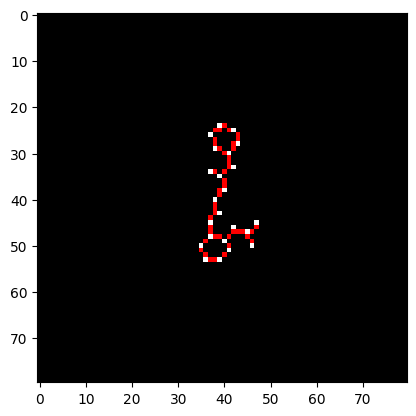

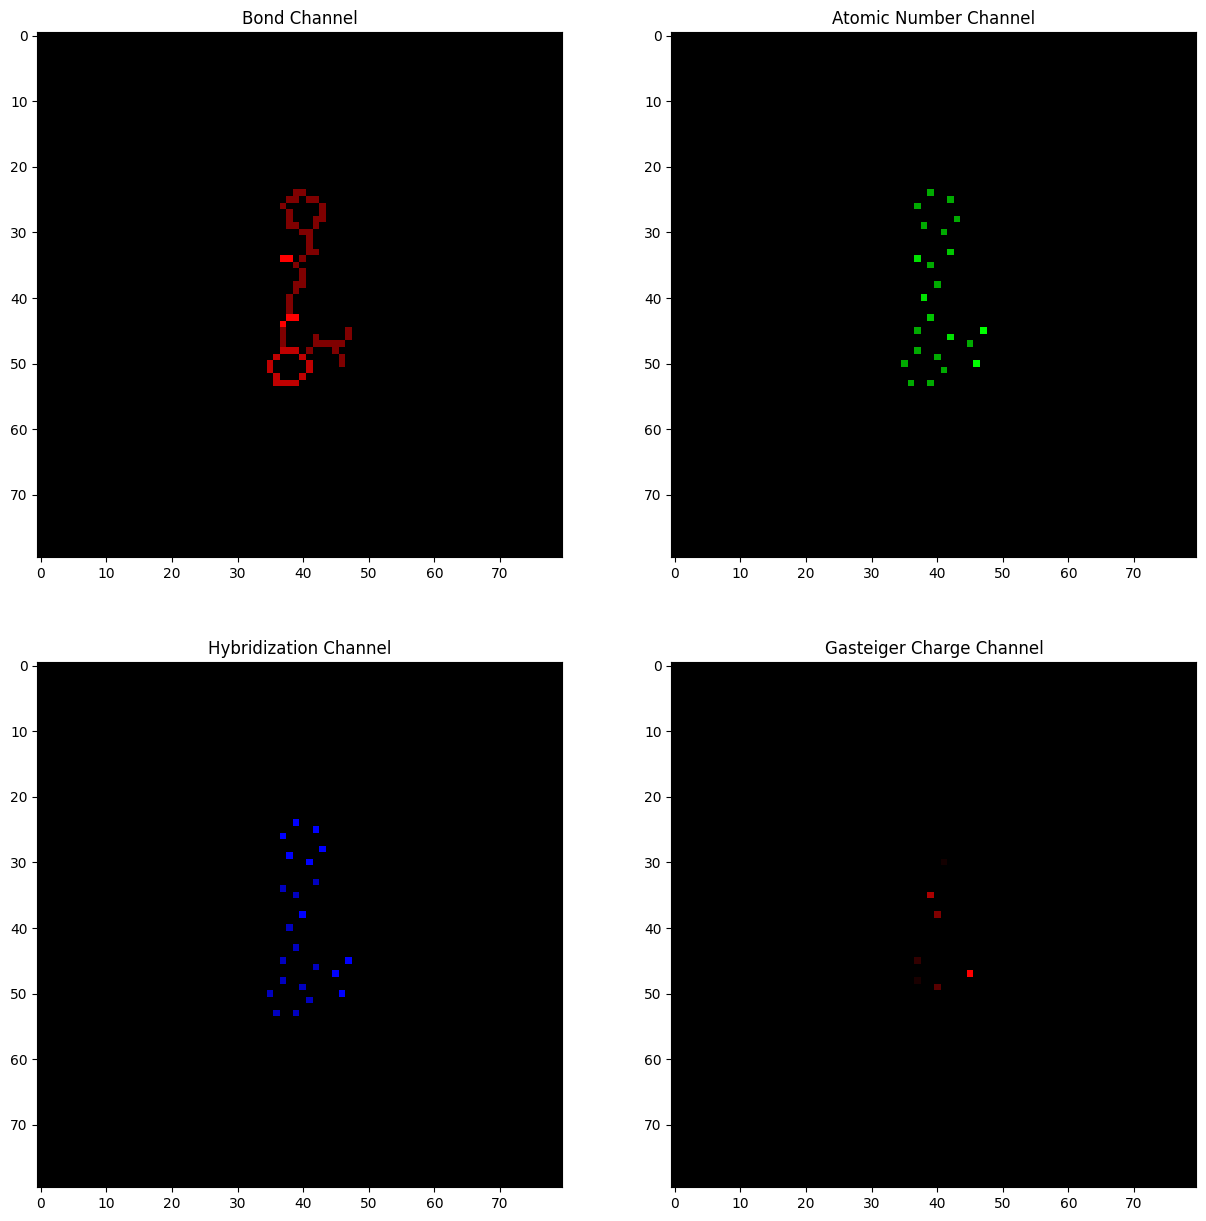

In [46]:
def show_channel(v, channel_ind):
    """
    Show a single channel of a 3D numpy array
    """
    v_copy = np.zeros(shape=(v.shape[0], v.shape[1], 3))
    if channel_ind >= 3:
        v_copy[:,:,0] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
    else:
        v_copy[:,:,channel_ind] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
        
    return v_copy


sample = train_df["molimage"].iloc[0]
plt.imshow(sample[:,:,:3])
ch1, ch2, ch3, ch4 = show_channel(sample, 0), show_channel(sample, 1), show_channel(sample, 2), show_channel(sample, 3)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].imshow(ch1)
ax[0, 1].imshow(ch2)
ax[1, 0].imshow(ch3)
ax[1, 1].imshow(ch4)
ax[0, 0].set_title("Bond Channel")
ax[0, 1].set_title("Atomic Number Channel")
ax[1, 0].set_title("Hybridization Channel")
ax[1, 1].set_title("Gasteiger Charge Channel")

The featurization is working correctly, we proceed to model building

# Model Building

The model was adpoted directly from the paper with `N` being selected as `32`

### `Block Architecture`
![Alt text](images/model_block_arch.png)

In [3]:
model = Chemception()
model = model.build()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 16)   592         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 24, 24, 64)   9280        ['conv2d_1[0][0]']               
             

# Preparing generator and data for fitting

![Alt text](Featurizer.png)

It can be observed from the above image the orientation difference between the original image and our featurization result. Since our featurization method in recontructing the molecule image using our selected features, we can assure the `0` intra-class variation, hence, we do not need augmentation.

In [48]:
# import keras
# from keras.layers import Flatten

# def Inception0(input):
#     tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
#     tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
#     tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
 
#     output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
#     return output

# def Inception(input):
#     tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
#     tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
#     tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
#     tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)
 
#     output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
#     return output



# input_img = Input(shape=X_train.shape[1:])
 
# x = Inception0(input_img)
# x = Inception(x)
# x = Inception(x)
# od=int(x.shape[1])
# x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
# x = Flatten()(x)
# x = Dense(100, activation='relu')(x)
# output = Dense(1, activation='sigmoid')(x)
 
# model = Model(inputs=input_img, outputs=output)
# optimizer = Adam(lr=0.00025)
# model.compile(loss="binary_crossentropy", optimizer=optimizer)
# model.summary()

In [49]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(data_format='channels_last')

train_df.dropna(subset=["molimage"], inplace=True)
X_train = train_df["molimage"].to_numpy()
X_train = np.stack(X_train, axis=0)
y_train = train_df["label"]

batch_size=32
g = generator.flow(X_train, y_train, batch_size=batch_size, shuffle=True)



# Fit the model

#### Load validation data

In [50]:
val_df = pd.read_csv('val_aid686978.csv')
# val_df = val_df.sample(frac=0.2)
val_df['mol'] = val_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
val_df['molimage'] = val_df['mol'].apply(featureizer.featurize)
val_df.dropna(subset=["molimage"], inplace=True)
X_val = val_df["molimage"].to_numpy()
X_val = np.stack(X_val, axis=0)
y_val = val_df["label"]

In [51]:

steps_per_epoch = X_train.shape[0]//batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=1e-6, verbose=1)


history = model.fit(g,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100, verbose=2,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr]
                    )

Epoch 1/100
272/272 - 17s - loss: 0.6940 - val_loss: 0.6931 - lr: 0.0010 - 17s/epoch - 63ms/step
Epoch 2/100
272/272 - 9s - loss: 0.6932 - val_loss: 0.6932 - lr: 0.0010 - 9s/epoch - 32ms/step
Epoch 3/100
272/272 - 8s - loss: 0.6932 - val_loss: 0.6931 - lr: 0.0010 - 8s/epoch - 31ms/step
Epoch 4/100
272/272 - 8s - loss: 0.6932 - val_loss: 0.6931 - lr: 0.0010 - 8s/epoch - 30ms/step
Epoch 5/100


KeyboardInterrupt: 

# Plot the history

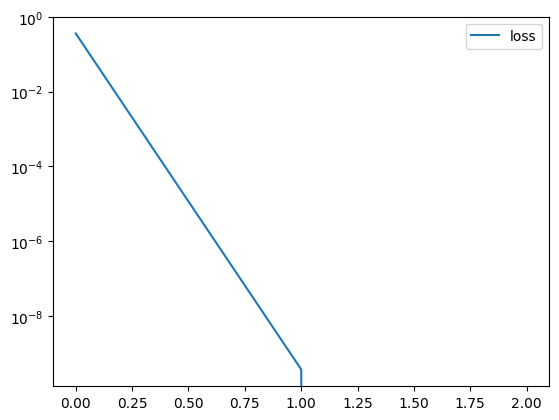

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'loss')
plt.legend()
plt.yscale("log")

# Test the model on test data

In [ ]:
test_df = pd.read_csv('test_aid686978.csv')
# test_df = test_df.sample(frac=0.2)
test_df['mol'] = test_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
test_df['molimage'] = test_df['mol'].apply(featureizer.featurize)
test_df.dropna(subset=["molimage"], inplace=True)
X_test = np.array(list(test_df["molimage"]))
y_test = test_df["label"]

In [ ]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 9ms/step - loss: 4.4580


4.457980155944824

In [1]:
from chemception import Chemception

model = Chemception()
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



TypeError: Inputs to a layer should be tensors. Got '<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x1071f3a90>>' (of type <class 'method'>) as input for layer 'conv2d'.

In [10]:
#reload modules
%load_ext autoreload
%autoreload 2

from keras.models import Model
from chemception.chemception import Chemception_sequential
model = Chemception_sequential()
model.build((None, 48, 48, 4))
model.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
inceptionA
Model: "chemception_sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_232 (Conv2D)         (None, 24, 24, 8)         296       
                                                                 
 conv2d_233 (Conv2D)         (None, 24, 24, 8)         584       
                                                                 
 conv2d_234 (Conv2D)         (None, 24, 24, 64)        4672      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_235 (Conv2D)         (None, 12, 12, 64)        4160      
                                                                 
 conv2d_2